# Data exploration with Boston Bikeshare csvs

In [172]:
import pandas as pd
import numpy as np
import glob
import os
import copy

In [20]:
def readDir():
    """
    Returns a dataframe of the data files in the directory with the bikeshare data.
    """
    data = pd.DataFrame()
    
    path = os.path.join(os.sep, "raid", "public_data", "Bike_Share_Data", "Boston")
    
    for filename in glob.glob(os.path.join(path, '*.csv')):
        # Get the filesizes in megabytes
        f_size = os.path.getsize(filename) / 1_000_000
        
        # A dictionary stores information about the files to be be put in the df
        file = {"Filename": filename, "Size (mb)": f_size}
        data = data.append(file, ignore_index=True)
        
    return data

def openCSV(files, index):
    """
    Using filenames retrieved with readDir, use this function to open a specific
    csv. Returns a dataframe with the data requested.
    """
    data = pd.read_csv(files.loc[index, 'Filename'])
    if index != 0:
        data['starttime'] = pd.to_datetime(data['starttime'])
        data['stoptime'] = pd.to_datetime(data['stoptime'])
#         files.loc[index, 'Month'] = data.loc[0, 'starttime'].month
#         files.loc[index, 'Year']  = data.loc[0, 'starttime'].year
    return data
    

In [21]:
files = readDir()

In [22]:
files.loc[0, 'Filename']

'/raid/public_data/Bike_Share_Data/Boston/Hubway_Stations_as_of_July_2017.csv'

In [33]:
# files.to_csv("data_info.csv", index=False)

In [32]:
def usePerMonth(files_df):
    """
    Takes the dataframe of files and returns a new dataframe of files with rides per calendar month.
    """
    resdf = pd.DataFrame()
    
    for i in range(1, files_df.index.values.shape[0]):
        df = openCSV(files_df, i)
        resdf = resdf.append({'Date': df.loc[0, 'starttime'], 'Rides': df.index.values.shape[0]}, ignore_index=True)
        
    return resdf

In [33]:
df = usePerMonth(files)

In [173]:
import matplotlib.pyplot as plt
import seaborn as sns

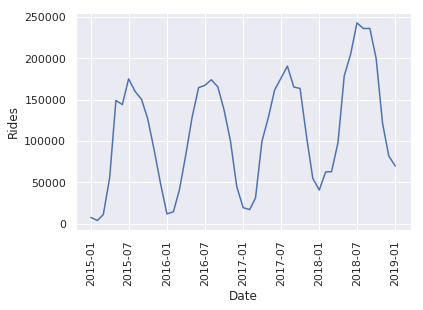

In [37]:
sns.set()

sns.lineplot(x='Date', y='Rides', data=df)
plt.xticks(rotation=90);

# Make a dataframe that holds the number of rides per day

In [159]:
data = []

for i in range(files.index.values.shape[0]):
    data.append(openCSV(files, i))

In [160]:
fulldf = pd.concat(data[1:])

In [161]:
fulldf.index = fulldf['starttime']

In [162]:
counts = fulldf.groupby(fulldf.index.date).count()

In [163]:
counts.head()

,tripduration,starttime,stoptime,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,end station longitude,bikeid,usertype,birth year,gender
2015-01-01,127,127,127,127,127,127,127,127,127,127,127,127,127,127,127
2015-01-02,213,213,213,213,213,213,213,213,213,213,213,213,213,213,213
2015-01-03,142,142,142,142,142,142,142,142,142,142,142,142,142,142,142
2015-01-04,112,112,112,112,112,112,112,112,112,112,112,112,112,112,112
2015-01-05,337,337,337,337,337,337,337,337,337,337,337,337,337,337,337


In [164]:
counts.loc[pd.to_datetime('2015-02-03').date()]

tripduration               81
starttime                  81
stoptime                   81
start station id           81
start station name         81
start station latitude     81
start station longitude    81
end station id             81
end station name           81
end station latitude       81
end station longitude      81
bikeid                     81
usertype                   81
birth year                 81
gender                     81
Name: 2015-02-03, dtype: int64

# Merge rides/day data with the weather data 

In [165]:
# Import weather csv
w_data = pd.read_csv(os.path.join("weather_data", "boston_weather_clean.csv"))

In [166]:
w_data.head()

,Year,Month,Day,High Temp (F),Avg Temp (F),Low Temp (F),High Dew Point (F),Avg Dew Point (F),Low Dew Point (F),High Humidity (%),...,Low Sea Level Press (in),High Visibility (mi),Avg Visibility (mi),Low Visibility (mi),High Wind (mph),Avg Wind (mph),High Wind Gust (mph),Snowfall (in),Precip (in),Events
0,2008,1,1,40,34,28,37,31,22,92,...,29.56,10,8,1,23,10,36,0.18,0.18,Both
1,2008,1,2,33,22,10,28,18,-3,82,...,29.55,10,10,9,28,15,38,0.00,0.00,Snow
2,2008,1,3,14,11,7,-3,-7,-9,60,...,30.22,10,10,10,25,17,32,0.00,0.00,None
3,2008,1,4,32,20,8,13,5,-8,63,...,30.37,10,10,10,23,12,28,0.00,0.00,None
4,2008,1,5,42,35,27,26,16,12,64,...,30.17,10,10,10,16,9,23,0.00,0.00,None


In [167]:
def mergeData(weatherDF, ridesperdayDF):
    """
    Takes two dataframes, one of weather per day and another about how many
    bike rides were taken per day, and returns a new dataframe with combined
    data.
    """
    resdf = copy.copy(ridesperdayDF).drop(ridesperdayDF.columns.values[1:], axis=1)
    resdf = resdf.rename(columns={'tripduration': 'num_rides'})
    
    for i in weatherDF[weatherDF['Year'] >= 2015].index.values:
        date = pd.to_datetime("%d-%d-%d" % (weatherDF.loc[i, 'Year'], 
                                            weatherDF.loc[i, 'Month'], 
                                            weatherDF.loc[i, 'Day'])).date()
        
        for feat in ['Avg Temp (F)', 'Snowfall (in)', 'Precip (in)', 'Events']:
            resdf.loc[date, feat] = weatherDF.loc[i, feat]
            
    return resdf

In [168]:
resdata = mergeData(w_data, counts)

In [171]:
df = resdata.dropna()

In [174]:
df.head()

,num_rides,Avg Temp (F),Snowfall (in),Precip (in),Events
2015-01-01,127.0,28.0,0.00,0.00,None
2015-01-02,213.0,36.0,0.00,0.00,None
2015-01-03,142.0,30.0,0.62,0.62,Both
2015-01-04,112.0,44.0,0.00,0.57,Rain
2015-01-05,337.0,34.0,0.00,0.00,None


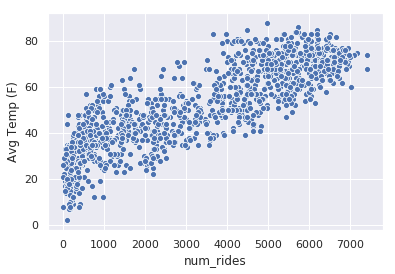

In [175]:
sns.set()

sns.scatterplot(x='num_rides', y='Avg Temp (F)', data=df)

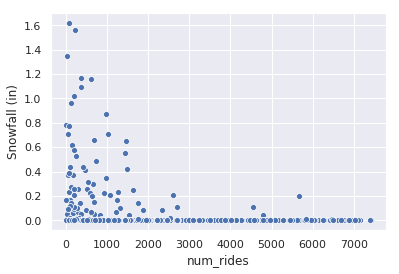

In [178]:
sns.scatterplot(x='num_rides', y='Snowfall (in)', data=df)